# 1 正则化线性回归
这一部分，我们需要先对一个水库的流出水量以及水库水位进行正则化线性归回。然后将会探讨方差-偏差的问题

## 1.1 数据可视化

In [38]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
data = sio.loadmat('E:\机器学习(吴恩达)\ML数据\ml_ex5\ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

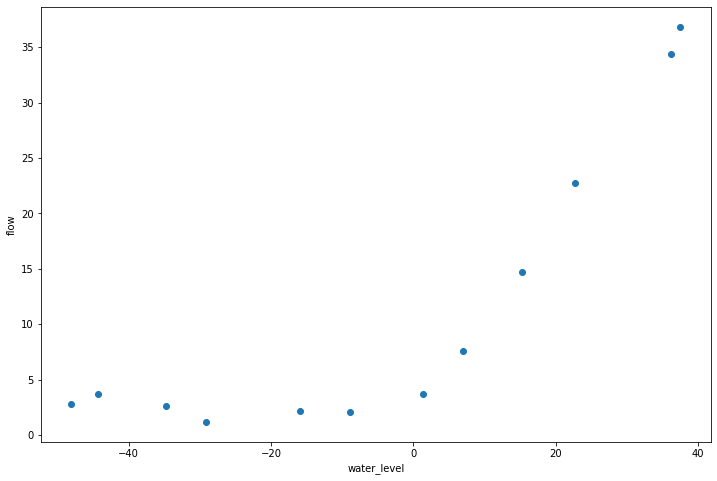

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X, y)
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
plt.show()

## 1.2 正则化线性回归代价函数

其中$\lambda$是正则化参数，他控制了正则化的程度。正则化项在原来的代价$J$上加了一个惩罚项。随着参数$\theta_j$的变大，惩罚项也会增大。另外，你不需要正则化$\theta_0$
下面完场计算正则化线性回归代价函数的代码。theta初始值为[1,1]，输出应该为303.993

In [41]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [42]:
def cost(theta, X, y):
    m = X.shape[0]

    inner = X @ theta - y 

    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [43]:
def costReg(theta, X, y, reg = 1):
    
    m = X.shape[0]

    regularized_term = (reg / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [44]:
theta = np.ones(X.shape[1])
costReg(theta, X, y, 1)

303.9931922202643

## 1.3 正则化线性回归的梯度

In [45]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [46]:
def gradientReg(theta, X, y, reg):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (reg / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [47]:
gradientReg(theta, X, y, 1)

array([-15.30301567, 598.25074417])

## 1.4 拟合线性回归
调用工具库找到$\theta$最优解，在这个部分，我们令$\lambda=0$。因为我们现在训练的是2维的$\theta$，所以正则化不会对这种低维的$\theta$有很大的帮助。
完成之后，将数据和拟合曲线可视化。

In [48]:
theta = np.ones(X.shape[1])
final_theta = opt.minimize(fun=costReg, x0=theta, args=(X, y, 0), method='TNC', jac=gradientReg, options={'disp': True}).x
final_theta

array([13.08790348,  0.36777923])

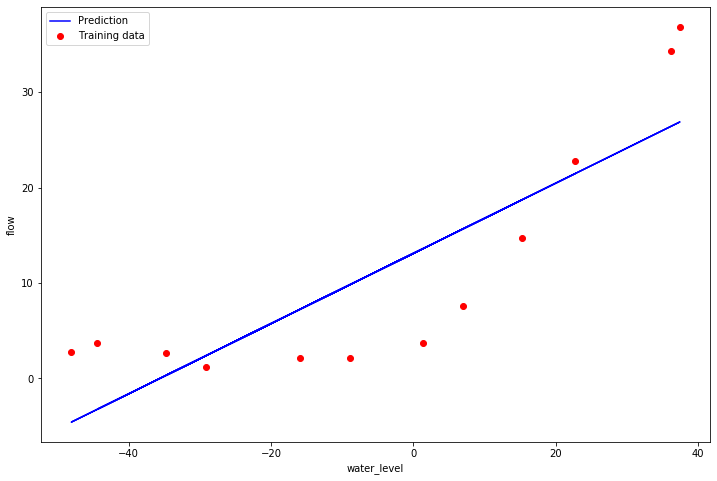

In [49]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X[:,1], y, c='r', label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, c='b', label="Prediction")
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
ax.legend()
plt.show()

# 2 方差和偏差
机器学习中的一个重要概念是偏差-方差权衡。偏差较大的模型会欠拟合，而方差较大的模型会过拟合。这部分会让你画出学习曲线来判断方差和偏差的问题。

## 2.1 学习曲线
1.使用训练集的子集来拟合应模型
2.在计算训练代价和验证集代价时，没有用正则化
3.记住使用相同的训练集子集来计算训练代价

In [50]:
def linear_regression(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=costReg,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=gradientReg,
                       options={'disp': True})
    return res

In [51]:
training_cost, cv_cost = [], []

In [52]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression(X[:i, :], y[:i], 0)
    
    tc = costReg(res.x, X[:i, :], y[:i], 0)
    cv = costReg(res.x, Xval, yval, 0)
   
    training_cost.append(tc)
    cv_cost.append(cv)

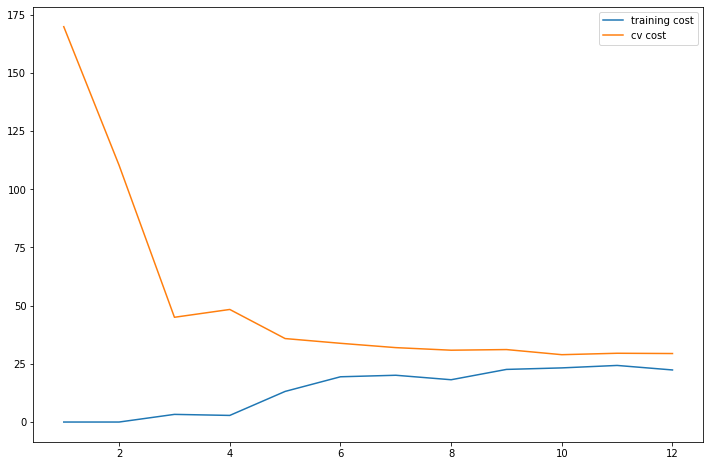

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend()
plt.show()

# 3 多项式回归
线性回归对于现有数据来说太简单了，会欠拟合，我们需要多添加一些特征。
写一个函数，输入原始X，和幂的次数p，返回X的1到p次幂

In [54]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.values if as_ndarray else df

In [55]:
data = sio.loadmat('E:\机器学习(吴恩达)\ML数据\ml_ex5\ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

In [57]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 3.1 多项式回归
1. 使用之前的代价函数和梯度函数
2. 扩展特征到8阶特征
3. 使用 **归一化** 来处理 $x^n$ 
4. $\lambda=0$

In [58]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [59]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = normalize_feature(df).values

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [60]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

In [61]:
# 画出学习曲线
#首先，我们没有使用正则化，所以 $\lambda=0$

def plot_learning_curve(X, Xinit, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    fig, ax = plt.subplots(2,  1, figsize=(12, 12))
    ax[0].plot(np.arange(1, m + 1), training_cost, label='training cost')
    ax[0].plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    ax[0].legend()

    fitx = np.linspace(-50, 50, 100) 
    fitxtmp = prepare_poly_data(fitx, power=8)
    fity = np.dot(prepare_poly_data(fitx, power=8)[0], linear_regression(X, y, l).x.T)
    
    ax[1].plot(fitx, fity, c='r', label='fitcurve')
    ax[1].scatter(Xinit, y, c='b', label='initial_Xy')
    
    ax[1].set_xlabel('water_level')
    ax[1].set_ylabel('flow')

In [ ]:
plot_learning_curve(X_poly, X, y, Xval_poly, yval, l=0)
plt.show()
